In [ ]:
! pip install tensorflow_model_optimization

In [ ]:
import keras
import numpy as np
from keras import Sequential, Model
from keras.layers import Conv2D, GlobalAvgPool2D, AvgPool2D, MaxPool2D, Flatten, Dense, Softmax, DepthwiseConv2D, BatchNormalization, ReLU
from keras.preprocessing import image
from tensorflow import lite
import pandas as pd
from PIL import Image
import tensorflow_model_optimization as tfmot
from matplotlib import pyplot as plt

## Building model.
The structure of MobileNet_v1 is shown in the figure below:  
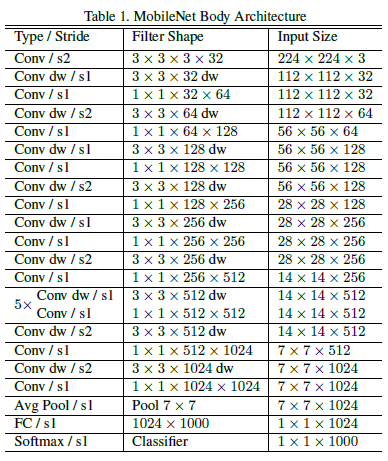  
The original model has 1000 classes to be predicted. but in GTSRB dataset, there are only 43 classes to be predicted. So in the final layer, I use `model.add(Dense(43))`.

In [ ]:
model = Sequential()
model.add(Conv2D(32, (3, 3), strides=2, input_shape=(224, 224, 3), padding='same'))
model.add(BatchNormalization())
model.add(ReLU())
model.add(DepthwiseConv2D((3, 3), strides=1, padding='same'))
model.add(BatchNormalization())
model.add(ReLU())
model.add(Conv2D(64, (1, 1)))
model.add(BatchNormalization())
model.add(ReLU())
model.add(DepthwiseConv2D((3, 3), strides=2, padding='same'))
model.add(BatchNormalization())
model.add(ReLU())
model.add(Conv2D(128, (1, 1)))
model.add(BatchNormalization())
model.add(ReLU())
model.add(DepthwiseConv2D((3, 3), strides=1, padding='same'))
model.add(BatchNormalization())
model.add(ReLU())
model.add(Conv2D(128, (1, 1)))
model.add(BatchNormalization())
model.add(ReLU())
model.add(DepthwiseConv2D((3, 3), strides=2, padding='same'))
model.add(BatchNormalization())
model.add(ReLU())
model.add(Conv2D(256, (1, 1)))
model.add(BatchNormalization())
model.add(ReLU())
model.add(DepthwiseConv2D((3, 3), strides=1, padding='same'))
model.add(BatchNormalization())
model.add(ReLU())
model.add(Conv2D(256, (1, 1)))
model.add(BatchNormalization())
model.add(ReLU())
model.add(DepthwiseConv2D((3, 3), strides=2, padding='same'))
model.add(BatchNormalization())
model.add(ReLU())
model.add(Conv2D(512, (1, 1)))
model.add(BatchNormalization())
model.add(ReLU())
for i in range(5):
    model.add(DepthwiseConv2D((3, 3), strides=1, padding='same'))
    model.add(BatchNormalization())
    model.add(ReLU())
    model.add(Conv2D(512, (1, 1)))
    model.add(BatchNormalization())
    model.add(ReLU())
model.add(DepthwiseConv2D((3, 3), strides=2, padding='same'))
model.add(BatchNormalization())
model.add(ReLU())
model.add(Conv2D(1024, (1, 1)))
model.add(BatchNormalization())
model.add(ReLU())
model.add(DepthwiseConv2D((3, 3), strides=2, padding='same'))
model.add(BatchNormalization())
model.add(ReLU())
model.add(Conv2D(1024, (1, 1)))
model.add(BatchNormalization())
model.add(ReLU())
# model.add(AvgPool2D((7, 7)))
model.add(GlobalAvgPool2D())
model.add(Flatten())
model.add(Dense(43))
model.add(Softmax())

model.compile(
    loss='categorical_crossentropy',
    optimizer='adam',
    metrics=['accuracy']
)

model.summary()

## Generate the dataset.

In [ ]:
trainDataFrame = pd.read_csv('../input/gtsrb-german-traffic-sign/Train.csv')
testDataFrame = pd.read_csv('../input/gtsrb-german-traffic-sign/Test.csv')

trainDataFrame['ClassId'] = trainDataFrame['ClassId'].astype(str)
testDataFrame['ClassId'] = testDataFrame['ClassId'].astype(str)

for i in range(0, len(trainDataFrame['ClassId'])):
    if len(trainDataFrame['ClassId'][i]) == 1:
        trainDataFrame['ClassId'][i] = '0' + trainDataFrame['ClassId'][i]
for i in range(0, len(testDataFrame['ClassId'])):
    if len(testDataFrame['ClassId'][i]) == 1:
        testDataFrame['ClassId'][i] = '0' + testDataFrame['ClassId'][i]

print(trainDataFrame['ClassId'][20], trainDataFrame['Path'][20])
img = Image.open('../input/gtsrb-german-traffic-sign/' + trainDataFrame['Path'][20])
plt.imshow(img)

In [ ]:
trainDataGen = image.ImageDataGenerator(
#     rescale=1./255,
#     shear_range=0.2
)
testDataGen = image.ImageDataGenerator(
#     rescale=1./255
)

trainDataGenerator = trainDataGen.flow_from_dataframe(
    dataframe=trainDataFrame,
    directory='../input/gtsrb-german-traffic-sign/',
    x_col='Path',
    y_col='ClassId',
    target_size=(224, 224),
    batch_size=64,
    class_mode='categorical'
)
testDataGenerator = testDataGen.flow_from_dataframe(
    dataframe=testDataFrame,
    directory='../input/gtsrb-german-traffic-sign/',
    x_col='Path',
    y_col='ClassId',
    target_size=(224, 224),
    batch_size=16,
    class_mode='categorical'
)

## Train model.

In [ ]:
history = model.fit(trainDataGenerator, epochs=3, verbose=1)

## Evaluate model.

In [ ]:
loss = history.history['loss']
acc = history.history['accuracy']
epoches = range(0, len(loss))
plt.plot(epoches, loss, 'b', label='training loss')
plt.legend()
plt.figure()
plt.plot(epoches, acc, 'g', label='training accuracy')
plt.legend()
plt.show()

In [ ]:
model.evaluate(testDataGenerator, verbose=1)

In [ ]:
test_batch = 2
plt.figure(figsize=(64, 64))
plt.tight_layout()
for i in range(0, 16):
    plt.subplot(16, 2, 2 * i + 1), plt.axis('off')
    plt.imshow(testDataGenerator[test_batch][0][i])
    pre = model.predict_classes(testDataGenerator[test_batch][0])
    img = Image.open('../input/gtsrb-german-traffic-sign/Meta/' + str(pre[i]) + '.png')
    plt.subplot(16, 2, 2 * i + 2), plt.axis('off')
    plt.imshow(img)

## Quantize

If you want to deploy the model on IoT devices or edge devices, you may think of quantized model to minimize the size of the model.

### Quantized model build.

In [ ]:
quantize_model = tfmot.quantization.keras.quantize_model

q_aware_model = quantize_model(model)

q_aware_model.compile(
    loss='categorical_crossentropy',
    optimizer='adam',
    metrics=['accuracy']
)

q_aware_model.summary()

### Quantized model train.

In [ ]:
q_aware_model.fit(trainDataGenerator, epochs=3, verbose=1)

### Evaluate quantized model.

In [ ]:
q_aware_model.evaluate(testDataGenerator, verbose=1)

## Save models.

In [ ]:
model.save('model/final/MobileNet.h5')
model.save_weights('model/final/MobileNet_weights.h5')
q_aware_model.save('model/final/MobileNet_quantized.h5')
q_aware_model.save('model/final/MobileNet_quantized_weights.h5')

## Convert the models into tflite model.

In [ ]:
converter = lite.TFLiteConverter.from_keras_model(q_aware_model)
converter.optimizations = [lite.Optimize.DEFAULT]
tfliteModel = converter.convert()
open('model/final/MobileNet.tflite', 'wb').write(tfliteModel)